<a href="https://colab.research.google.com/github/RozenkovAndrey/project_of_yandex_practicum/blob/main/%D0%9D%D0%B5%D0%B4%D0%B2%D0%B8%D0%B6%D0%B8%D0%BC%D0%BE%D1%81%D1%82%D1%8C/%D0%BD%D0%B5%D0%B4%D0%B2%D0%B8%D0%B6%D0%B8%D0%BC%D0%BE%D1%81%D1%82%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

In [20]:
!gdown --id 1P_eJEPgN6JCLjClPnqgJIEBAtGoSw2kE

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1P_eJEPgN6JCLjClPnqgJIEBAtGoSw2kE
To: /content/real_estate_data.csv
100% 3.21M/3.21M [00:00<00:00, 205MB/s]


# Откройте файл с данными и изучите общую информацию. 

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import seaborn as sns
import sklearn.linear_model as lm
import statsmodels.api as sm
import statsmodels.formula.api as smf
plt.style.use('classic')

In [22]:
df = pd.read_csv('real_estate_data.csv', sep = '\t')

# Предобработка данных

## Знакомство с данными

In [23]:
# Вывожу первые 5 строк для ознакомления
pd.set_option('display.max_columns', None)
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [24]:
#Вывожу общую информацию о датасете (название столбцов и количество ненулевых значений)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [25]:
#Вывожу количество пустых значений по столбцам
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

При первоначальном поверхностном знакомстве с данными были замечены следующие проблемы с данными:
- first_day_exposition (дата публикации) имеет неверный тип данных. Является строкой
- floors_total (количество этажей в доме) можно из float перевести в int. Тк не может быть дробное количество этажей.
- is_apartment имеет типа данных строка. Должно быть булевым значением. Однако столбец в исследовании нам не нужен.
- balcony можно смело менять на int. Не бывает дробное число балконов.
- days_exposition количество дней показа в датасете - целое число.
- многие другие столбы имеют не тот тип
Так же во многих столбцах имеется значение NaN. Возможно данные заполнялись пользователем и эти поля значения не были указаны.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faaf5e8b450>,
      dtype=object)

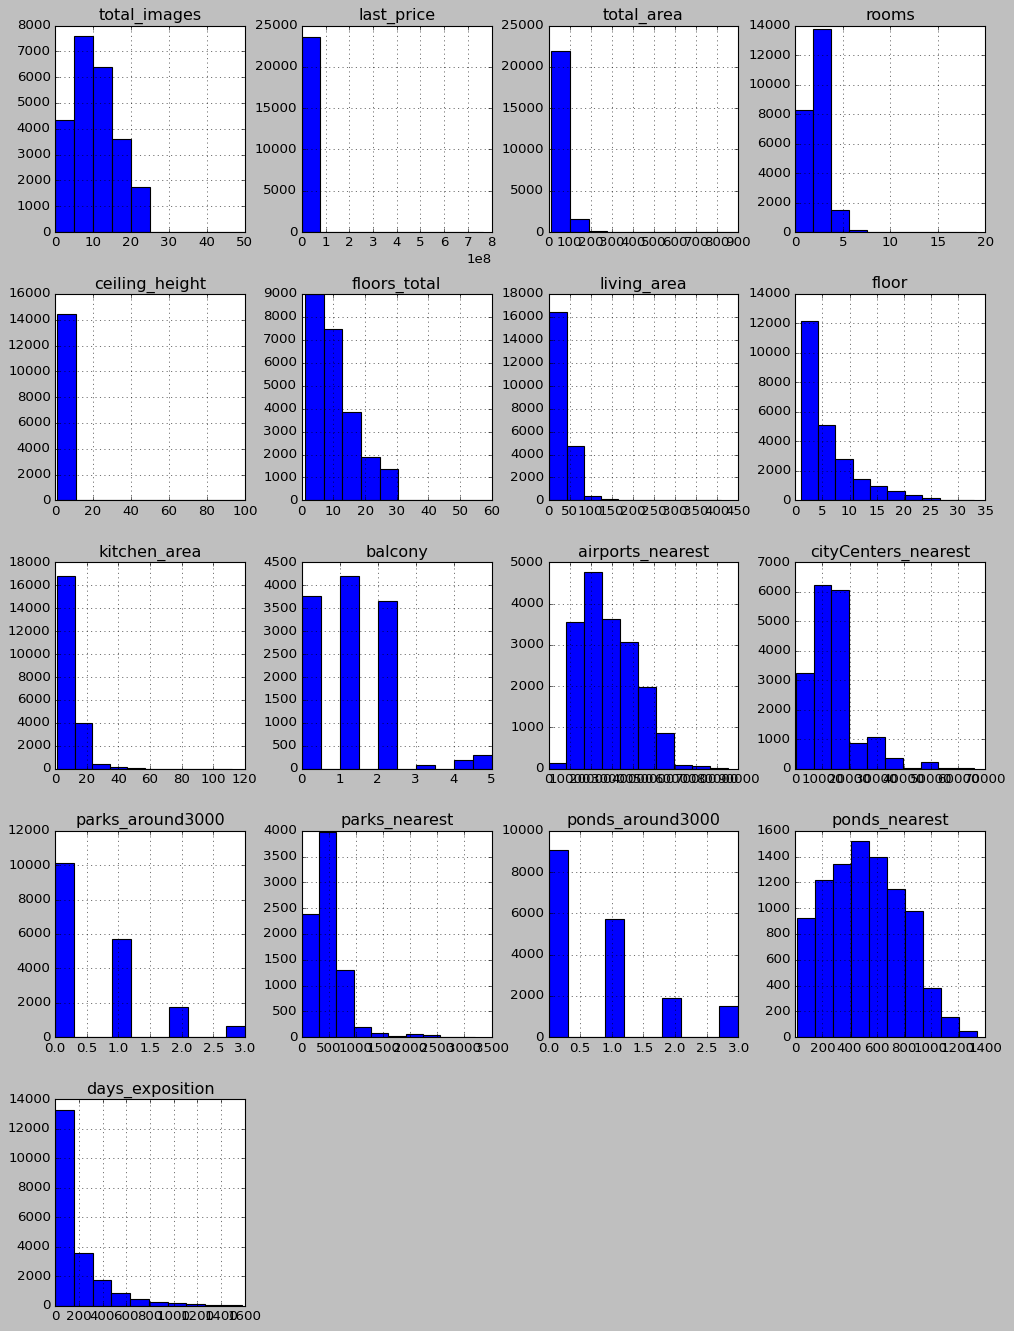

In [33]:
df.hist(figsize=(15, 20))

In [27]:
old_data = df.shape[0]

## Заполнение пропусков и удаление/замена аномальных значений, замена форматов

- ceiling_height           9195 - заменим значения медианой и удалим выбросы с помощью функции
- floors_total               86 - заменим на медиану, меняем формат
- living_area              1903 - напишем функцию и поставим медианной для разных категорий
- is_apartment            20924 - все пропуски заменим False (98,2 имеющихся заполеннных значений - это False), меняем формат 
- kitchen_area             2278 - поставим медианное
- balcony                 11519 - будем руководствоваться логикой и смотреть фотки квартир, ещё интересно было бы применить рандомный лес из машинного обучения (например в студии и аппартаментах наврятли будет балкон),чтобы предсказать есть балкон или нет, но будем руководствоваться логикой, что если не указано, значит его нет, ставим значение 0, меняем формат
- locality_name              49 -удалим пропуски
- airports_nearest         5542 - оставим без изменений
- cityCenters_nearest      5519 - оставим без изменений
- parks_around3000         5518 - оставим без изменений
- parks_nearest           15620 - оставим без изменений
- ponds_around3000         5518 - оставим без изменений
- ponds_nearest           14589 - оставим без изменений
- days_exposition          3181 - заменим медианным значением, меняем формат


In [42]:
# Расчёты по значениям для принятия решений, что делать с пропусками 
#(удаляем, если маленький процент пропусков и не можем поставить медиану)

print('Процент пропусков floors_total:', round(86*100/len(df),2), '%')
print('Процент пропусков locality_name:', round(49*100/len(df),2), '%')

# кол-во заполненых is_apartment со значением False
m = df.query('is_apartment == False')['is_apartment'].count()
# общее кол-во заполненых is_apartment
g = df[df['is_apartment'].notna()]['is_apartment'].count() 
print('Процент значений is_apartment = False из заполненого:', round(m*100/g,2), '%')

# кол-во заполненых balcony 
n = df[df['balcony'].notna() == True]
n = n['balcony'].count() 
# общее кол-во заполненых balcony со значением 0 
f = df[df['balcony'] == 0]['balcony'].count() 
print('Процент значений квартир без балконов из заполненного:', round(f*100/n,2), '%')

Процент пропусков floors_total: 0.36 %
Процент пропусков locality_name: 0.21 %
Процент значений is_apartment = False из заполненого: 98.2 %
Процент значений квартир без балконов из заполненного: 30.85 %


Работаем со столбцом ceiling_height (заполняем пустые строки)

In [45]:
#Пробую различные вариации фильтров с пустыми значениями: (аппартаменты и балкон, аппартаменты и площадь кухни, номер этажа 
# и высота потолков и др.) и смотрю какие пропуски коррелируют между собой
df1 = df[(df['is_apartment'].isna()) &  (df['balcony'].isna())]
len(df1)

11042

- Если есть пропуски в is_apartment, то вероятнее всего они есть и в столбцах kitchen_area, balcony и ceiling_height. Это может показывать, что либо человек ленив и не хочет заполнять все данные или у него их нет, или не хочет их показывать по какой либо причине. 
- Гипотеза о том, что на первом этаже должны быть высокие потолки под магазины не подтвердилась, если в данных не заполнена строка is_apartment, то часто не заполнены и kitchen_area, balcony и высота потолка.

In [46]:
# Проверяю на выбросы по значению высоты потолков
df2 = df.query('ceiling_height>7')
len(df2)

29

При выводе информации о высоте потолков видны аномальные значения (32,27,25,100) м. В химической лаборатории на производстве у нас были потолки в 10 м, также высокие потолки в библиотеке им.Ленина, соборах, но для квартир такие потолки не характерны. Низкие или нулевые потолки могут быть у участков, коммерческих объектов. Квартиры с высотой более 20 м (по снипу высота потолков не должна быть менее 2,5 м, хотя Питер - город с историей) делим на 10, а с высотой до 2 м и более 7 м - удаляем из датасета.

In [47]:
#Написал функцию  и избавился от аномальных по высоте значений и перезаписал датасет
def normal_ceiling_height(height):
    if height>=20:
        height = height/10      
    return height        

In [48]:
df['ceiling_height'] = df['ceiling_height'].apply(normal_ceiling_height)

In [49]:
df.shape

(23699, 22)

In [50]:
median = df['ceiling_height'].median()
df['ceiling_height'] = df['ceiling_height'].fillna(median)

In [51]:
#Удалил на аномальные значения по высоте
df = df[(df['ceiling_height']<=7.0) & (df['ceiling_height']>=2.0)]

In [52]:
df.shape

(23689, 22)

Работаем со столбцом locality_name	

In [53]:
#Проверяем дупликаты по регистру
len(df.locality_name.unique())

365

In [54]:
#Делаю нижний регистр для всех значений столбца
j = list(df.locality_name.astype(str).unique())
k = [x.lower() for x in j]
len(set(k))

365

Дупликатов по регистру нет

In [57]:
#Сделал очистку столбца locality_name
name_city = df['locality_name'].unique()
asd = list(df['locality_name'])

asd = set(asd)
asd = list(asd)
print(len(asd))



sp10 = []
k = 0
try:
    for i in asd:
        
        i = i.replace('поселок городского типа','').replace('деревня','').replace('коттеджный посёлок','') \
        .replace('поселок','').replace('городской посёлок','').replace('посёлок при железнодорожной станции','') \
        .replace('садоводческое некоммерческое товарищество','').replace('село','').replace('посёлок','') \
              .replace('садовое товарищество','').replace('городского типа','').replace('городской','').replace('коттеджный','') \
                   .replace('имени','')
        sp10.append(i)

except:
    k += 1
print(k)
sp10 = [i.lstrip() for i in sp10]
print(len(sp10))
sp10 = set(sp10)
sp10  = list(sp10)
print(len(sp10))
print(sp10)

365
1
0
0
[]


In [58]:
# Удаляем недостающие значения и заменим неявные дупликаты
df = df[df['locality_name'].notna() == True]
for n in sp10:            
    def originals(name):          
        if n in name:
            return n
        else:
            return name
    df['locality_name'] = df['locality_name'].apply(originals)

print(df['locality_name'].unique())

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

In [59]:
display(df['locality_name'])

0            Санкт-Петербург
1             посёлок Шушары
2            Санкт-Петербург
3            Санкт-Петербург
4            Санкт-Петербург
                ...         
23694        Санкт-Петербург
23695                  Тосно
23696       село Рождествено
23697        Санкт-Петербург
23698    поселок Новый Учхоз
Name: locality_name, Length: 23640, dtype: object

Работаем со столбцом floors_total               

In [ ]:
# Меняем формат и удаляем пустые ячейки в столбце floors_total
#print(df.floors_total.median())
df['floors_total'] = df['floors_total'].fillna(0).astype('int64')
df = df[df['floors_total'] != 0]

#print(df['floors_total'].unique())
#print(df.floors_total.value_counts())
#print(df.isna().sum())

   

Работаем со столбцом living_area              

In [61]:
#Делаем срез по количеству комнат и убираем квартиры с нулевым значением комнат
df = df.query('rooms != 0')
df.rooms.unique()

array([ 3,  1,  2,  4,  5,  6,  7, 11,  8, 14, 10, 15,  9, 19, 16, 12])

In [62]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.65,11,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.65,5,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.65,14,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [63]:
# Считаю соотношение медианной жилой площади и общей и нахожу соотношение
#Заполняю пропуски в пропусках жилой площади умножением общей на коэффициент 
# и проверяю, что всё заполнено
import warnings
warnings.simplefilter("ignore")

df['living_area'] = df['living_area'].fillna(0).copy()
df = df.copy()

#print(df['living_area'].median()/df['total_area'].median())

try:
    for i in range(len(list(df['living_area']))):
        if df['living_area'].loc[df.index[i]] == 0:
            df['living_area'].loc[df.index[i]] = df['total_area'].loc[df.index[i]]*0.561
except:
    pass


#print(df['living_area'].value_counts())
#print(df.isna().sum())       

In [ ]:
df.head()

Работаем со столбцом is_apartment

In [64]:
# Поставим значение False на месте пропусков и поменяем формат
df.loc[df['is_apartment'].isna(), 'is_apartment'] = False
df['is_apartment'] = df['is_apartment'].astype(bool)
#df.info()
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2026
balcony                 11401
locality_name               0
airports_nearest         5445
cityCenters_nearest      5422
parks_around3000         5421
parks_nearest           15363
ponds_around3000         5421
ponds_nearest           14398
days_exposition          3157
dtype: int64

Работаем со столбцом kitchen_area

In [65]:
# Считаю соотношение медианной кухонной площади и общей и нахожу соотношение
#Заполняю пропуски в столбце кухонной площади умножением общей на коэффициент 
# и проверяю, что всё заполнено
import warnings
warnings.simplefilter("ignore")

df['kitchen_area'] = df['kitchen_area'].fillna(0).copy()
df = df.copy()

print(df['kitchen_area'].median()/df['total_area'].median())

try:
    for i in range(len(list(df['kitchen_area']))):
        if df['kitchen_area'].loc[df.index[i]] == 0:
            df['kitchen_area'].loc[df.index[i]] = df['total_area'].loc[df.index[i]]*0.173
except:
    pass

0.17307692307692307


In [66]:
# Делаю функцию для проверки, чтобы площадь кухни и жилая не были больше общей площади и удаляю аномалии
def test_kitchen(row):
    kitchen_squere = row['kitchen_area']
    living_squere = row['living_area']
    total_area1 = row['total_area']
    total_squere = living_squere+kitchen_squere
    if total_squere<total_area1:
        return 'норма'
    else:
        return 'ошибка'
df['test'] = df.apply(test_kitchen, axis = 1)
df['test'].value_counts()
print(len(df))
df = df.loc[df['test'] != 'ошибка']
print(len(df))

23361
23194


Работаем со столбцом balcony 

In [67]:
#Cтавим значение 0 на месте пропусков, меняем формат
df['balcony'] = df['balcony'].fillna(0).astype('int64')

Работаем со столбцом days_exposition

In [68]:
# Данный столбец решили оставить без изменений, посовещавшись с коллегами, пришли к выводу, что объявления могут 
#могут ещё висеть

Работаем со столбцом first_day_exposition

In [69]:
#Поменяем формат времени
import pandas as pd
try:
    df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%d')
except:
    pass

Меняем не поменяные форматы для столбцов

In [72]:
# Муняю форматы оставшихся столбцов
# Меняю на числовой формат
sp11 = ['total_images', 'last_price', 'rooms', 'floor', 'parks_around3000', 'ponds_around3000']
try:
    for i in sp11:
        df[i] = df[i].astype('int64')
except:
    pass

# Меняю на с плавающей запятой формат
sp22 = ['ceiling_height', 'living_area', 'kitchen_area', 'airports_nearest', 'cityCenters_nearest', 'parks_nearest', \
        'ponds_nearest']
try:
    for i in sp22:
        df[i] = df[i].astype('float64')
except:
    pass

#Меняю на булев формат
sp33 = ['studio', 'open_plan']
try:
    for i in sp33:
        df[i] = df[i].astype('bool')
except:
    pass
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23194 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23194 non-null  int64         
 1   last_price            23194 non-null  int64         
 2   total_area            23194 non-null  float64       
 3   first_day_exposition  23194 non-null  datetime64[ns]
 4   rooms                 23194 non-null  int64         
 5   ceiling_height        23194 non-null  float64       
 6   floors_total          23194 non-null  int64         
 7   living_area           23194 non-null  float64       
 8   floor                 23194 non-null  int64         
 9   is_apartment          23194 non-null  bool          
 10  studio                23194 non-null  bool          
 11  open_plan             23194 non-null  bool          
 12  kitchen_area          23194 non-null  float64       
 13  balcony         

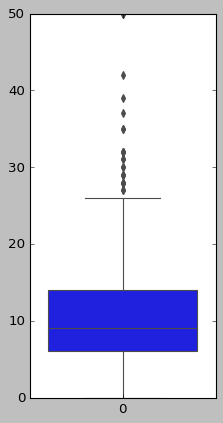

In [73]:
#Строю ящик с усами для определения выбросов для количества фотографий
#(при удалении выбросов, я не углублялся в статистику
#и не расчитывал межквартильный диапазон *1.5 и интрервал, а осонвывался на логике)
f, ax = plt.subplots(figsize=(3, 6))
fig = sns.boxplot(data=df['total_images'])

В некоторых случаях фоток аж около 50, но судя по квантилям боллее 
99% количества фоток не будут превышать 20 штук для квартиры 

In [74]:
#Смотрим квантили по категориям
df.quantile([0.1, 0.99], interpolation='nearest')

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0.10,2,2500000,33.0,1,2.50,5,16.55,1,False,False,False,6.0,0,13484.0,4768.0,0.0,159.0,0.0,145.0,17.0
0.99,20,36000000,197.9,5,3.56,26,122.00,23,False,False,False,35.1,5,58571.0,50125.0,3.0,2102.0,3.0,1159.0,1070.0


In [75]:
#Возьмём с запасом, вдруг у когота 19-ти комнатная квартира и фоткать нужно много)))
df = df.loc[df['total_images'] < 30].copy()
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,test
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.000,8,False,False,False,25.000,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,норма
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.600,1,False,False,False,11.000,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,норма
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.300,4,False,False,False,8.300,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,норма
3,0,64900000,159.0,2015-07-24,3,2.65,14,89.199,9,False,False,False,27.507,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,норма
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.000,13,False,False,False,41.000,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,норма


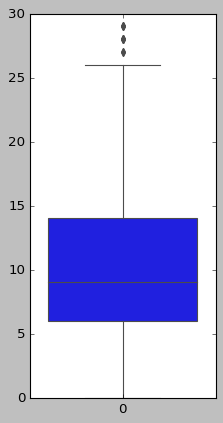

In [76]:
#После того как убрали аномальные значения, боксплот выглядит так, другое дело
f, ax = plt.subplots(figsize=(3, 6))
fig = sns.boxplot(data=df['total_images'])

In [77]:
# Разбиваю на одинаковые интервалы значения столбца last_price и 
import pandas as pd
import matplotlib.pyplot as plt

df['Номер интервала'] = pd.cut(df.last_price, bins=10, labels=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

df['Значение интервала'] = pd.cut(df.last_price, bins=10)

an = df.loc[:,['Номер интервала','Значение интервала']].value_counts().copy()


display(an)
df['Номер интервала'].value_counts().reset_index().sort_values(by = 'index').reset_index(drop = True)#.set_index('index')

Номер интервала  Значение интервала        
1                (-750797.81, 76310971.0]      23113
2                (76310971.0, 152609752.0]        51
3                (152609752.0, 228908533.0]        6
4                (228908533.0, 305207314.0]        5
6                (381506095.0, 457804876.0]        2
5                (305207314.0, 381506095.0]        1
10               (686701219.0, 763000000.0]        1
dtype: int64

,index,Номер интервала
0,1,23113
1,2,51
2,3,6
3,4,5
4,5,1
5,6,2
6,7,0
7,8,0
8,9,0
9,10,1


Замечаю явное аномальное значение в столбце last_price, которое находится в интервале (686701219.0, 763000000.0]. Цена конечно ошеломляет, но возможно это ошибка оператора и её нужно разделить на 10, а то и больше) Принимаю решение удалить эту величину.

In [78]:
#Нахожу ещё аномальное значение в стоимости квартир и решаю сделать дополнительный
#фильтр с минимальной стоимостью квартир в 500000
min(df['last_price'])

12190

In [79]:
#Удаляю аномальное значение
df = df.loc[(df['last_price'] < 686701219.0) & (df['last_price'] > 500000)]
df['Номер интервала'].value_counts().reset_index().sort_values(by = 'index').reset_index(drop = True)

,index,Номер интервала
0,1,23096
1,2,51
2,3,6
3,4,5
4,5,1
5,6,2
6,7,0
7,8,0
8,9,0
9,10,0


In [80]:
# Смотрю оствшиеся значения дискретных переменных на аномалии
sp8 = ['balcony', 'rooms', 'floors_total', 'floor', 'parks_around3000', 'ponds_around3000']
try:
    for i in sp8:
        print(i, df[i].unique())
except:
    pass      

balcony [0 2 1 5 4 3]
rooms [ 3  1  2  4  5  6  7 11  8 14 10 15  9 19 16 12]
floors_total [16 11  5 14 12 26 24 27  9  6 17 25  3 23 19 18  4 22  8  2 10  7 13 15
 20 28 36 21 35 34 60  1 29 33 52]
floor [ 8  1  4  9 13  5  6 22 26  7  3  2 11 15 18 10 19 16 20 27 25 17 14 12
 21 28 24 23 30 29 32 33 31]
parks_around3000 [ 1.  0.  2. nan  3.]
ponds_around3000 [ 2.  0.  3.  1. nan]


В оставшихся дискретных значениях столбцов датасета аномальных значений не заметил

In [ ]:
# Смотрю оствшиеся значения непрерывных переменных на аномалии
sp9 = ['first_day_exposition', 'living_area', 'kitchen_area', 'days_exposition', 'total_area',
      'airports_nearest', 'cityCenters_nearest', 'parks_nearest', 'ponds_nearest']
try:
    for i in sp9:
        df['Номер интервала'] = pd.cut(df[i], bins=10, labels=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
        df['Значение интервала'] = pd.cut(df[i], bins=10)
        print(i)
        print(df.loc[:,['Номер интервала','Значение интервала']].value_counts().copy())
        print(df[i].value_counts().reset_index().sort_values(by = 'index').reset_index(drop = True))
        df = df.drop(['Номер интервала', 'Значение интервала'], axis=1)
except:
    pass

В непрерывных переменных замечены аномальные значения. 
Жилая площадь в квартире, студии или аппартаментах не должна быть меньше 10 м2.
Площадь кухни не должна быть менее 5 м2. Однако кухня может входить в состав комнаты, поэтому делаю фильтрацию только по общей площади квартиры(комнаты).

In [82]:
# Удаляю аномальные значения с маленькой площадбю из датасета
print('Длина датасета с аномальными площадями квартир',len(df))
df = df[df['living_area']>10.0]
print('Длина датасета без аномальных площадей квартир', len(df))
new_data = df.shape[0]
print('Отношение данных до фильтрации и после:', round(new_data/old_data, 3)) 

Длина датасета с аномальными площадями квартир 23161
Длина датасета без аномальных площадей квартир 23103
Отношение данных до фильтрации и после: 0.975


In [83]:
# Проверяю на явные дупликаты:
print('Дубликатов явных:', df.duplicated().sum())

Дубликатов явных: 0


# Подсчёт и добавление в таблицу новых столбцов

In [84]:
# Рассчёт и добавление цены квадратного метра
df['square_meter'] = df['last_price'] / df['total_area']

# Добавляю столбцы день недели/месяц и год публикации
df['day_name'] = (df['first_day_exposition'].dt.day_name())
df['month'] = df['first_day_exposition'].apply(lambda x: x.strftime('%m'))
df['year'] = df['first_day_exposition'].apply(lambda x: x.strftime('%Y'))

# Добавляю столбец с этажем квартиры.
def flat_floor (row):      
        try:
            if row['floor'] == 1:
                return 'первый'
            if row['floor'] == row['floors_total']:
                return 'последний'
            else:
                return 'другой'
        except:
            return 'не могу определить'

df['flat_floor'] = df.apply(flat_floor, axis=1)

# Добавляю столбец отношения жилой и общей площади
df['living_total_area'] = df['living_area'] / df['total_area']

# Добавляю столбец отношения площади кухни к общей
df['kitchen_total_are'] = df['kitchen_area'] / df['total_area']

# Добавляю расстояние в км до центра города
try:
    df['cityCenters_nearest_km'] = df['cityCenters_nearest']/1000
except:
    pass
df['cityCenters_nearest_km'] = df['cityCenters_nearest_km'].apply(lambda x: round(x, 0))
display(df)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,test,square_meter,day_name,month,year,flat_floor,living_total_area,kitchen_total_are,cityCenters_nearest_km
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.00000,8,False,False,False,25.0000,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,норма,120370.370370,Thursday,03,2019,другой,0.472222,0.231481,16.0
1,7,3350000,40.40,2018-12-04,1,2.65,11,18.60000,1,False,False,False,11.0000,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,норма,82920.792079,Tuesday,12,2018,первый,0.460396,0.272277,19.0
2,10,5196000,56.00,2015-08-20,2,2.65,5,34.30000,4,False,False,False,8.3000,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,норма,92785.714286,Thursday,08,2015,другой,0.612500,0.148214,14.0
3,0,64900000,159.00,2015-07-24,3,2.65,14,89.19900,9,False,False,False,27.5070,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,норма,408176.100629,Friday,07,2015,другой,0.561000,0.173000,7.0
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.00000,13,False,False,False,41.0000,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,норма,100000.000000,Tuesday,06,2018,другой,0.320000,0.410000,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000,133.81,2017-03-21,3,3.70,5,73.30000,3,False,False,False,13.8300,0,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN,норма,72490.845228,Tuesday,03,2017,другой,0.547792,0.103356,4.0
23695,14,3100000,59.00,2018-01-15,3,2.65,5,38.00000,4,False,False,False,8.5000,0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0,норма,52542.372881,Monday,01,2018,другой,0.644068,0.144068,NaN
23696,18,2500000,56.70,2018-02-11,2,2.65,3,29.70000,1,False,False,False,9.8091,0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN,норма,44091.710758,Sunday,02,2018,первый,0.523810,0.173000,NaN
23697,13,11475000,76.75,2017-03-28,2,3.00,17,43.05675,12,False,False,False,23.3000,2,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0,норма,149511.400651,Tuesday,03,2017,другой,0.561000,0.303583,10.0


# Исследовательский анализ данных

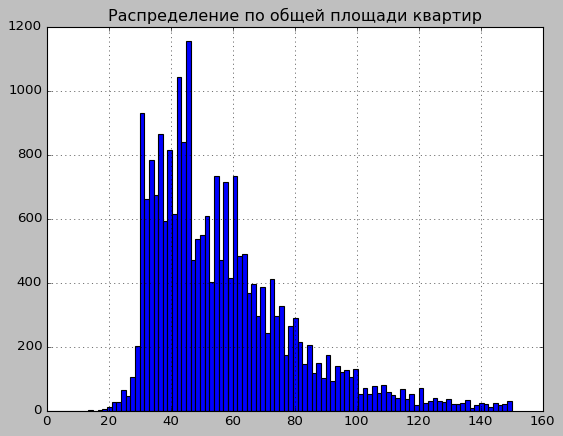

In [85]:
# Строю гистограмму для общей площади квартир
df['total_area'].hist(bins= 100, range=(0, 150))
plt.title('Распределение по общей площади квартир')
plt.show()

На гистограмме видно несколько пиков и наиболее встречаемые квартиры с площадью в диапазоне от 25 до 100 м2. Также далее видно, что преобладают одно и двух комнатные квартиры, для которых как раз характерна такая площадь.

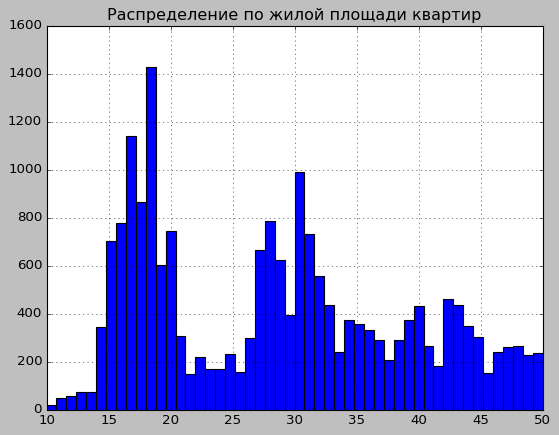

In [87]:
# Строю гистограмму для жилой площади квартир
df['living_area'].hist(bins= 50, range=(10, 50))
plt.title('Распределение по жилой площади квартир')
plt.show()

Гистограмма подтверждает, что жилая площадь наиболее сосредоточена в диапазоне от 15 до 45. На гистограмме видно два пика, один в районе 14-20 м. Такие площади очень характерны для студий и, если проводить аналогии с Москвой, то в Питере тоже много студий, это связано с бизнесом, их проще купить и потом перепродать и они наиболее доступны населению по доходам и ценовой политике. Те, у кого с доходами получше берут однушки с площадью побольше в районе 30м - это второй пик на гистограмме.

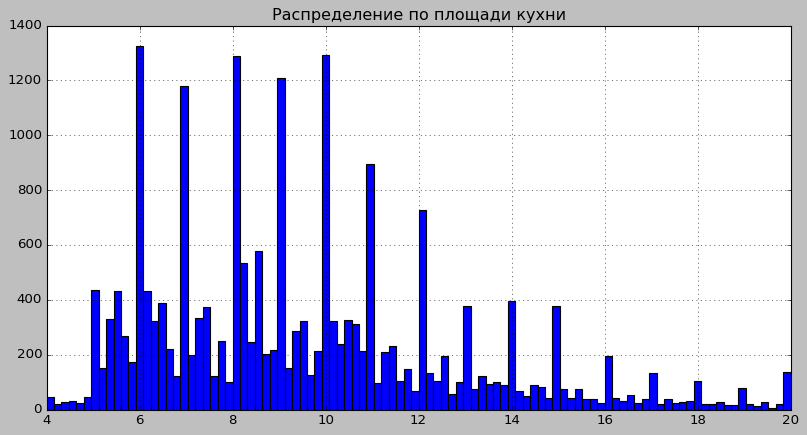

In [88]:
# Строю гистограмму для площади кухни
df['kitchen_area'].hist(bins= 100, range=(4, 20), figsize = (12,6))
plt.title('Распределение по площади кухни')
plt.show()

Наиболее характерные кухни в районе 5-18 метров. В снипе прописано, что дома кухней меньше 5 метров строить нельзя (не считая студий и аппартаментов, где кухня может входить в состав комнаты). Конечно, хорошо, когда большая кухня, но не каждому она по карману и спрос рождает предложение. 

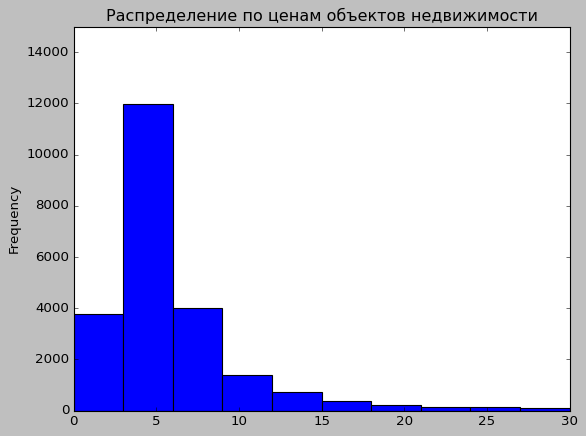

In [89]:
# Строю гистограмму для цен объектов недвижимости
df['last_price2'] = df['last_price']/1000000
df['last_price2'].plot(kind = 'hist', range = (0, 30))
plt.ylim([0, 15000])
plt.title('Распределение по ценам объектов недвижимости')
plt.show()

По диаграмме видно, что наиболее встречаемые цены на квартиры в районе от 3 до 5 млн.

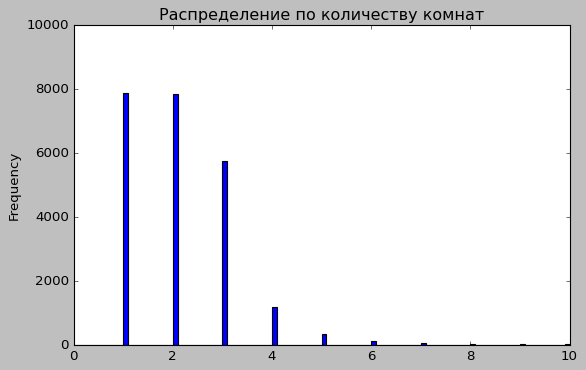

In [90]:
# Строю гистограмму для количества комнат
df['rooms'].plot(kind = 'hist', bins= 100, range=(0, 10), figsize = (8,5), ylim=(0,10000))
plt.title('Распределение по количеству комнат')
plt.show()

Видно, что наиболее встречаемые объекты недвижимости - это 1,2 и 3-ёх комнатные. 

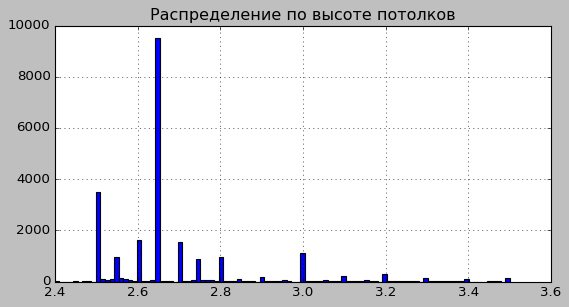

In [91]:
# Строю гистограмму для высоты потолков квартир
df['ceiling_height'].hist(bins= 100, figsize = (8,4), range = (2.4,3.5))
plt.title('Распределение по высоте потолков')
plt.show()

Видно, что наиболее встречаемая высота потолков в квартирах примерно 2.5 и 2.7 м, что согласуется со снипами. 

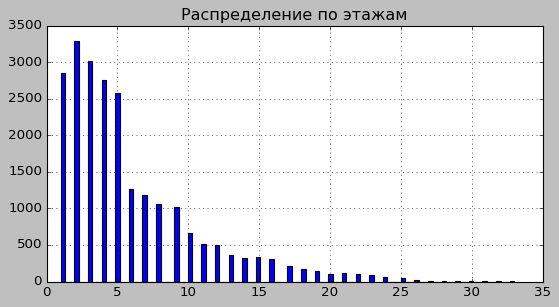

In [92]:
# Строю гистограмму для этажей квартиры
df['floor'].hist(bins= 100, figsize = (8,4))
plt.title('Распределение по этажам')
plt.show()
#df['floor'].value_counts()

По статистике должно было быть самым встречаемым этажом 1, но количество вторых и третьих опережает. 

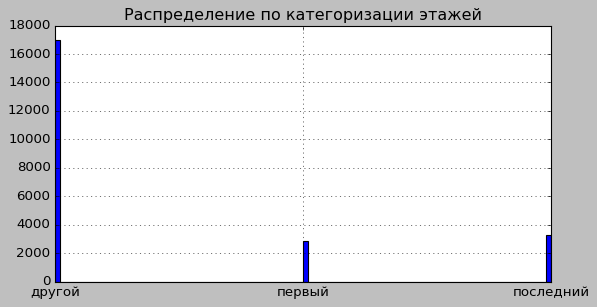

In [93]:
# Строю гистограмму для типов этажей квартир («первый», «последний», «другой»)
df['flat_floor'].hist(bins= 100, figsize = (8,4))
plt.title('Распределение по категоризации этажей')
plt.show()

Других этажей в продаже как и ожидалось больше, а вот последние продают чаще первых.

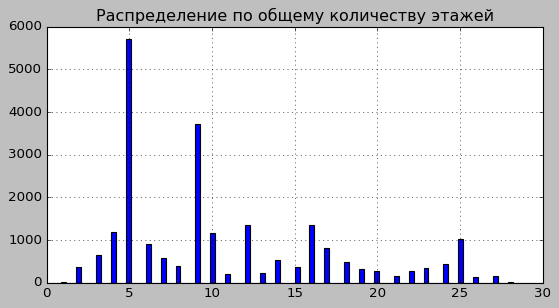

In [94]:
# Строю гистограмму для общее количество этажей в доме
df['floors_total'].hist(bins= 100, figsize = (8,4), range = (0,30))
plt.title('Распределение по общему количеству этажей')
plt.show()
#df['floors_total'].value_counts()

В Питере и окресностях преобладает жильё с этажностью в 5 и 9 этажей.

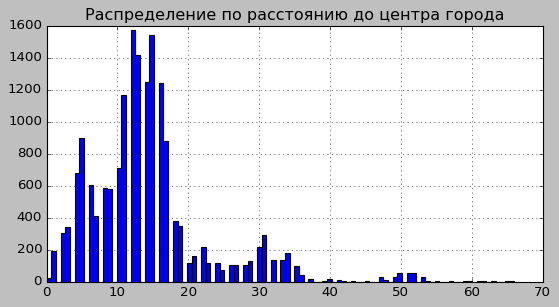

In [95]:
# Строю гистограмму для расстояние до центра города в метрах
df['cityCenters_nearest_km'].hist(bins= 100, figsize = (8,4))
plt.title('Распределение по расстоянию до центра города')
plt.show()

На гистограмме видно два пика, скорее всего один для построек в Питере, а второй для городов спутников и окраины Питера.

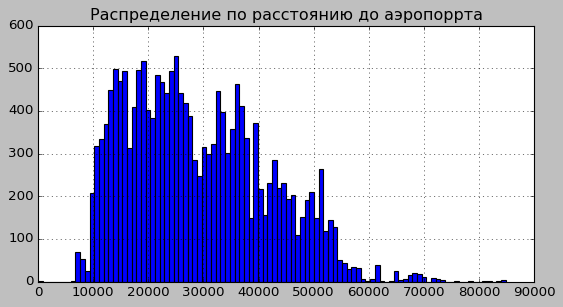

In [96]:
# Строю гистограмму для расстояние до ближайшего аэропорта
df['airports_nearest'].hist(bins= 100, figsize = (8,4))
plt.title('Распределение по расстоянию до аэропоррта')
plt.show()

Пассажирский аэропорт в Питере и окресностя один и расстояние до него в широком диапазоне и наиболее характерные расстояния находятся в диапазоне от 5 до 40 км.

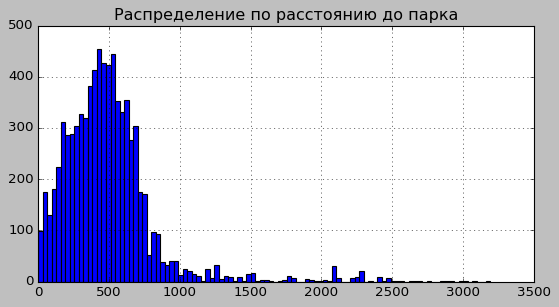

In [97]:
# Строю гистограмму для расстояние до ближайшего парка
df['parks_nearest'].hist(bins= 100, figsize = (8,4))
plt.title('Распределение по расстоянию до парка')
plt.show()

Наиболее характерное расстояние до парка от дома в диапазоне от 0 до 1000 м. Всё-таки в Питере и окресностях много парков. 

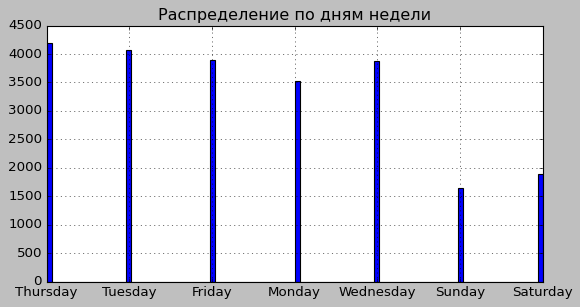

In [98]:
# Строю гистограмму для дня публикации объявления
df['day_name'].hist(bins= 100, figsize = (8,4))
plt.title('Распределение по дням недели')
plt.show()

В субботу и воскресение публикаций меньше, люди отдыхают.

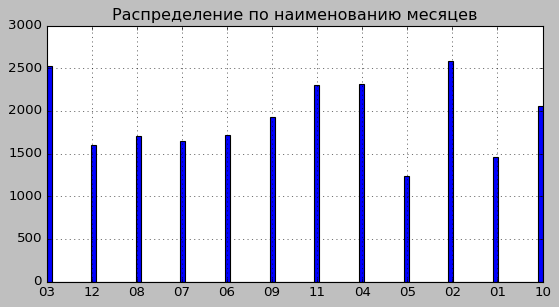

In [99]:
# Строю гистограмму для месяца публикации объявления
df['month'].hist(bins= 100, figsize = (8,4))
plt.title('Распределение по наименованию месяцев')
plt.show()

В месяцы, где много праздников (май, январь) и мало рабочих дней количество публикаций меньше остальных месяцев. 

In [100]:
# Изучаю скорость продаж квартир
print(df['days_exposition'].describe())

count    19974.000000
mean       181.744568
std        220.486561
min          1.000000
25%         45.000000
50%         96.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64


In [101]:
# Считаю процент проданных квартир в течение 100 дней для 1,2,3 комнатных
df1 = df.query('rooms == 1 and days_exposition<100')
df2 = df.query('rooms == 2 and days_exposition<100')
df3 = df.query('rooms == 3 and days_exposition<100')

f1 = (df1['days_exposition'].value_counts().head(10)*100/len(df1)).sum()
f2 = (df2['days_exposition'].value_counts().head(10)*100/len(df2)).sum()
f3 = (df3['days_exposition'].value_counts().head(10)*100/len(df3)).sum()

print(f1, f2, f3, sep = '\n')

27.55925365607665
27.692307692307693
28.25091575091575


Быстрее всего продаются трёшки из 1,2,3 - комнатных квартир

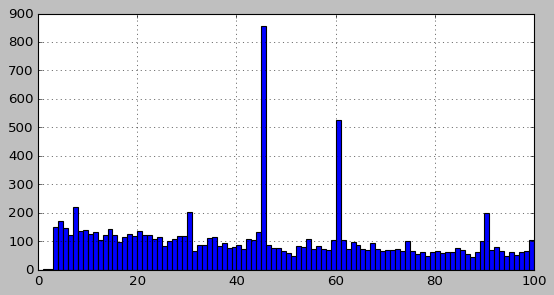

In [102]:
#Строю гистограмму дней размещения объявления о продаже
df['days_exposition'].hist(bins= 100, figsize = (8,4), range = (0, 100))

In [103]:
#print(df['days_exposition'].value_counts().head())

В яндекс недвижимости сроки платных объявлений в 45, 60 и 90 дней. После этих дней объявление о продаже закрывается и подаётся заного. Есть предположение, что это датасет для одного дня подачи объявлений квартир и динамике их продажи(иначе бы пиков на 45, 60 и 90 дней не было). Также люди могут уже найти покупателя и не снимать обЪявление. 

По яндекс нежвижимость:
- 45 дней - для комнаты и квартиры до 4,5 млн.
- 60 дней - дом, гараж, квартира от 4,5 до 10 млн., коммерческий объект
- 90 дней - дом, гараж, квартира от 10 млн.


Ранее правила могли быть другими. На гистограмме замечены пики на 7,30,45, 60 и 90 дней. 

                 days_exposition  last_price     rooms
days_exposition         1.000000    0.095521  0.124664
last_price              0.095521    1.000000  0.392109
rooms                   0.124664    0.392109  1.000000


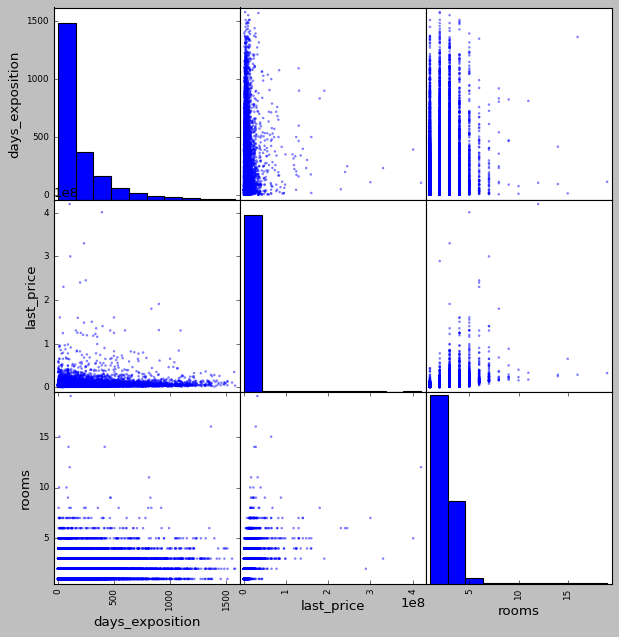

In [105]:
# Будет ли зависеть продолжительность продажи от стоимости недвижимости
df_multi = df[['days_exposition', 'last_price', 'rooms']]
print(df_multi.corr())
pd.plotting.scatter_matrix(df_multi, figsize=(9, 9), grid=True)
plt.show()

Судя по книге спин продаж, чем больше сумма покупки, тем дольше должен быть контакт продавца с покупателем и продажа должна быть дольше по времени. Так и получается, из гистограммы и значений дней показа объявлений прослеживается зависимость:

Для более 'дешёвого' сегмента:
- Дни показа:        45-  90-   135
- Снятых объявлений: 863 -530 - 43

Для среднего сегмента:
- Дни показа:        60- 120-180-240
- Снятых объявлений: 530- 62- 44 -21

Для дорогого сегмента:
- Дни показа:        90- 180-270
- Снятых объявлений: 530- 44- 15

Из этого можно сделать вывод, что для 'дешёвого сегмента', среднего и догогого сегментов быстрыми будут продажи 45,60 и 90 дней соответственно.

Средними по времени для этих сегментов будут продажи в интервалах 45-90, 60-120, 90-180.

Медленными будут продажи более 135, 180 и 270 дней соответственно.









# Определение коррелляций между данными и их визуализация

[Типы переменных](https://drive.google.com/file/d/18SQ4OXVgLjl1qQlLtc0hArO-TqWNOL61/view?usp=sharing)

По таблице выше опрделяю типы переменных для столбцов и в соответствии с ними выбираю нужный метод для определения зависимости цены на квартиру от выбранных факторов.

- непрерывные количественные: 'total_area', 'living_area', 'kitchen_area', 'last_price' 

- дискретные номинальные: 'rooms', 'flat_floor', 'day_name', 'month', 'year'


- Количественные/количественные (метод Пирсона)
- Количественные/номинальные (метод Спириена)



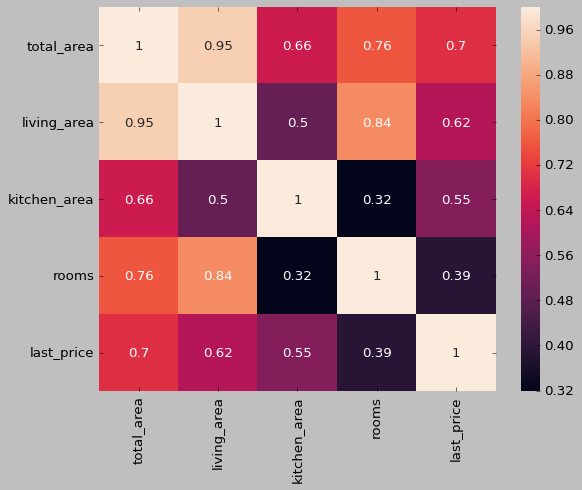

In [106]:
#Строю визуализацию для связи цены с количественными переменным
sns.heatmap(df[['total_area', 'living_area', 'kitchen_area', 'rooms', 'last_price']].corr(method='pearson'), annot=True)

Проверяю статичтическую значимость полученных результатов

In [107]:
scipy.stats.pearsonr(df.total_area, df.last_price)

(0.7026080731446669, 0.0)

In [108]:
scipy.stats.pearsonr(df.kitchen_area, df.last_price)

(0.5473019489821016, 0.0)

In [109]:
scipy.stats.pearsonr(df.living_area, df.last_price)

(0.6243143377780812, 0.0)

**Вывод:** Достаточно сильная прямая зависимость цены на квартиру от общей площади, слабее от площади кухни и жилой площади. Результаты коррелляций статистически значимы.

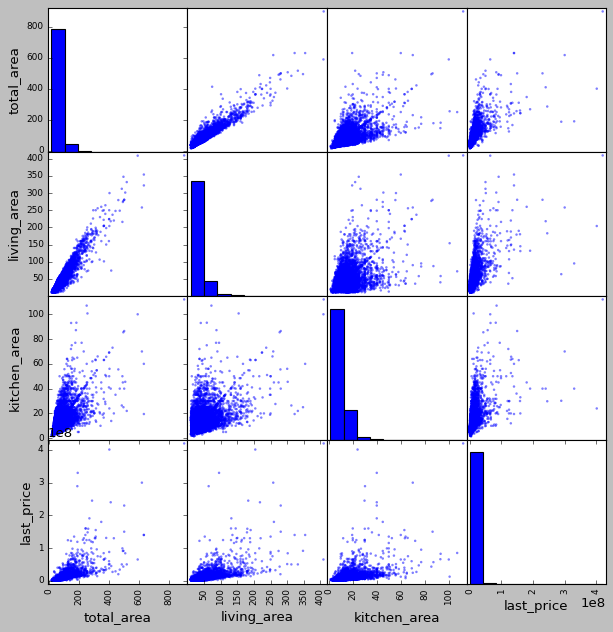

In [110]:
# Есть ли линейная зависимость цены от площади, числа комнат, удалённости от центра.
df_multi2 = df[['total_area', 'living_area', 'kitchen_area', 'last_price']]
pd.plotting.scatter_matrix(df_multi2, figsize=(9, 9), grid=True)
plt.show()


**Вывод:** С увеличением площадей (общей, жилой, кухни) цена на квартиру увеличивается как и следовало ожидать.

In [111]:
#Добавляю новый столбец, где дни недели заменяю цифрами для определения корелляции дней недели размещения с ценой на квартиры
df['flat_floor1'] = df['flat_floor'].replace('первый', 1).replace('другой', 2).replace('последний', 3)
#display(df.head())

In [112]:
df['day_name1'] = df['day_name'].replace('Monday', 1).replace('Tuesday', 2).replace('Wednesday', 3) \
.replace('Thursday', 4).replace('Friday', 5).replace('Saturday', 6).replace('Sunday', 7)
#display(df)

In [113]:
df['month'] = df['month'].astype('int64') 

In [114]:
df['year'] = df['year'].astype('int64')

In [115]:
scipy.stats.spearmanr(df.last_price, df.rooms)

SpearmanrResult(correlation=0.533357651213902, pvalue=0.0)

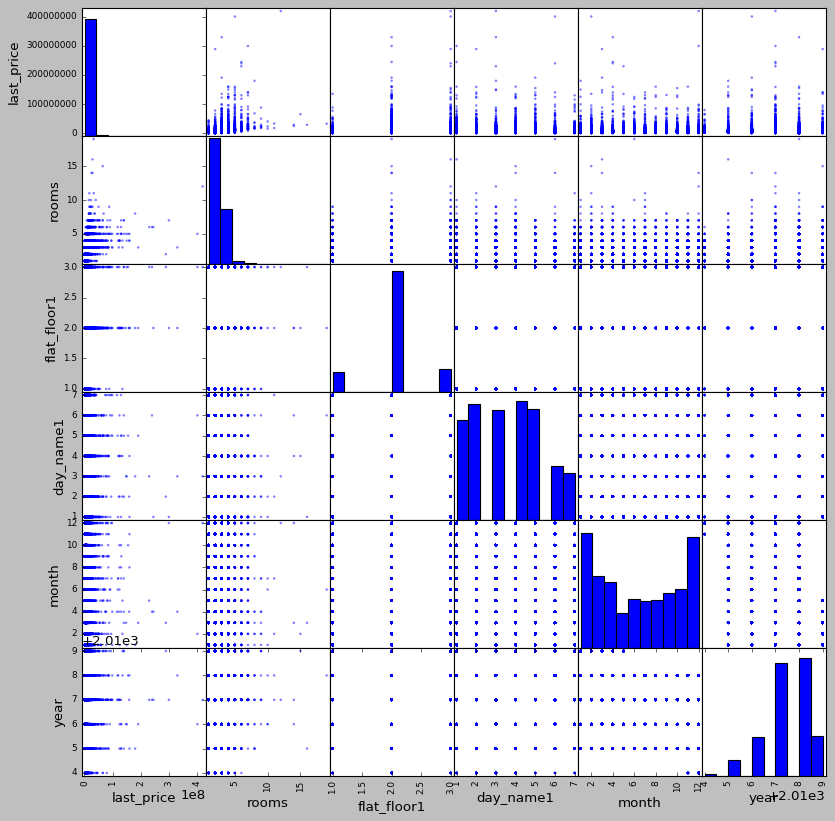

In [116]:
df_multi3 = df[['last_price', 'rooms', 'flat_floor1', 'day_name1', 'month', 'year']]
pd.plotting.scatter_matrix(df_multi3, figsize=(12, 12), grid=True)
plt.show()

В данном случае линейная зависимость есть между количеством комнат и ценой квартиры. Помним что коррелляция по методам Спирмена и Пирсона проверяет только линейную зависимость между переменными. Но зависимость может быть экспоненциальной или носить другой характер. Дополнительно сравниваю категориальные группы тех признаков, где точно нет линейной зависимости.

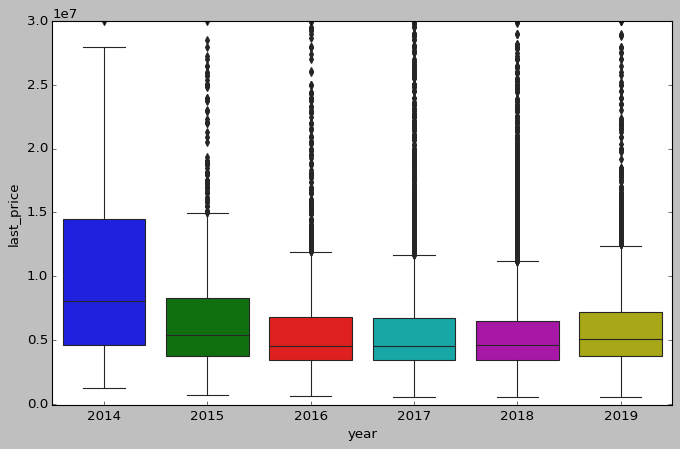

In [117]:
#Строю боксплоты, чтобы можно было сравнить группы по годам, дням недели, категории этажа, месяцам
f, ax = plt.subplots(figsize=(10, 6))
ax.set_ylim([-100000, 30000000])
fig = sns.boxplot(x='year', y='last_price', data=df)

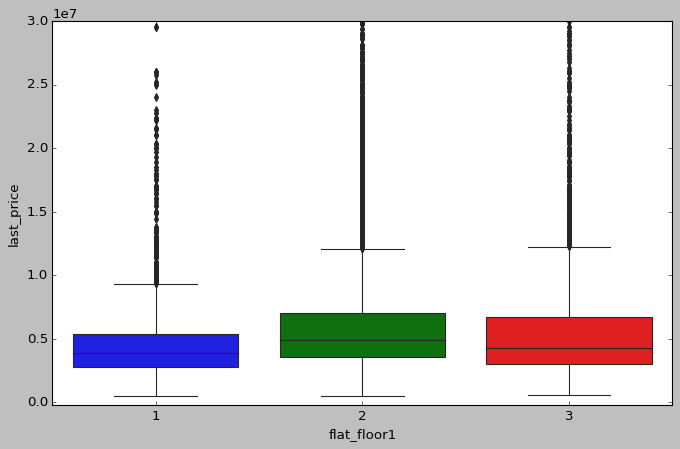

In [118]:
f, ax = plt.subplots(figsize=(10, 6))
ax.set_ylim([-200000, 30000000])
fig = sns.boxplot(x='flat_floor1', y='last_price', data=df)

In [119]:
min(df['last_price'])

520000

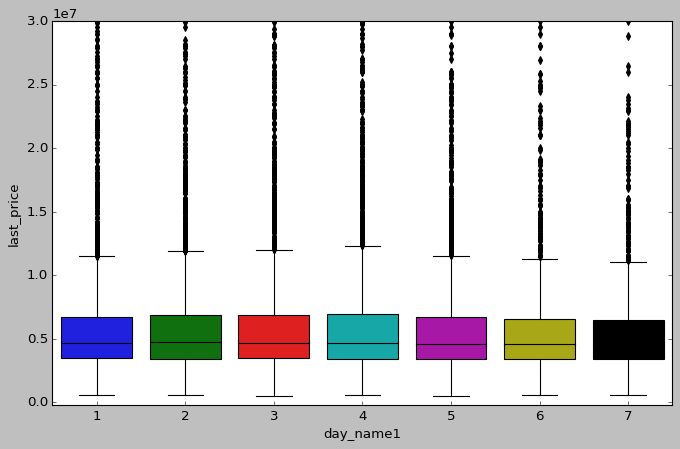

In [120]:
f, ax = plt.subplots(figsize=(10, 6))
ax.set_ylim([-200000, 30000000])
fig = sns.boxplot(x='day_name1', y='last_price', data=df)

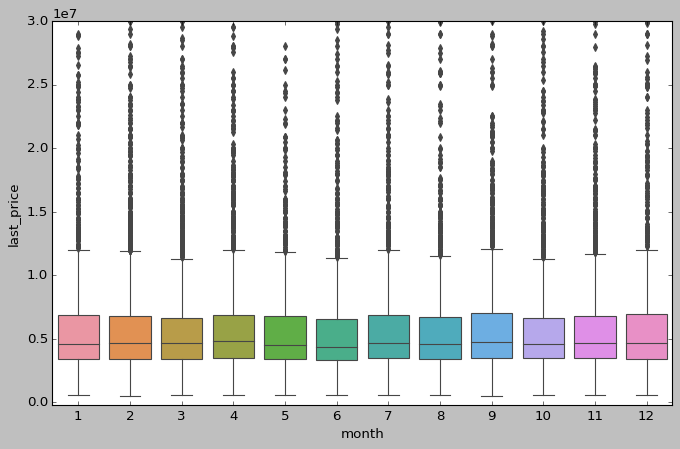

In [121]:
f, ax = plt.subplots(figsize=(10, 6))
ax.set_ylim([-200000, 30000000])
fig = sns.boxplot(x='month', y='last_price', data=df)

**Вывод:**
- В срезе годы видно, что в среднем цена в 2014 год на квартиры была выше, потом понижалась и далее в 2019 слегка поднялась. Если речь идёт об одних и тех же квартирах, то можно сделять вывод, что со временем люди, которые не могут продать квартиры понижают на них цену, дабы ускорить сделку.
- В категориях этажности видно, что в среднем цены на первый и последние этажи ниже, чем на другие.
- В категориях дни недели слегка ниже средняя цена на квартиры, размещённые в пятницу, субботу и воскресение, видимо людям, которые выставляют в эти дни более нуждаются в деньгах и работают, а те кто не работае и размещает объявления в будни не будет дешевить.
- В категориях месяцы средняя цена плюс / минус - одинаковая.

In [122]:
#Считаю среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений
df.groupby('locality_name').agg({'square_meter':['count', 'mean']}).sort_values(by=('square_meter', 'count'), \
                                                                                ascending = False).head(10)

square_meter               
                         count           mean
locality_name                                
Санкт-Петербург          15376  114441.305217
посёлок Мурино             485   84762.827136
посёлок Шушары             433   78298.223659
Всеволожск                 385   68553.083700
Пушкин                     367  103178.787096
Колпино                    337   75480.547446
посёлок Парголово          322   90248.786836
Гатчина                    303   68625.141404
деревня Кудрово            277   92235.199673
Выборг                     233   58256.817717

Наиболее дорогими по цене как и ожидалось квартиры в Санкт-Петербурге.

Ранее вы посчитали расстояние до центра в километрах.
Теперь выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра.
Опишите, как стоимость объектов зависит от расстояния до центра города.

,last_price
cityCenters_nearest_km,
0.000,"30,845,045.120"
1.000,"21,235,587.229"
2.000,"18,035,607.525"
3.000,"11,196,237.868"
4.000,"12,218,182.549"
5.000,"14,557,235.221"
6.000,"15,049,791.358"
7.000,"14,945,009.917"
8.000,"10,008,308.493"


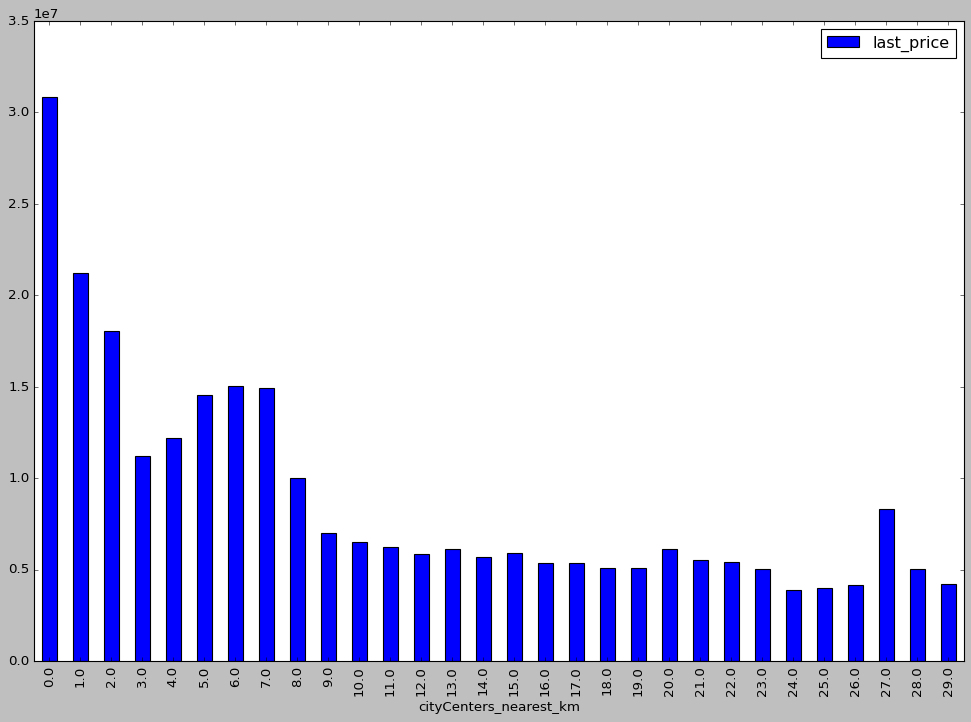

In [123]:
#Сортирую датасет по городу Санкт-Петербург и убираю пустые значения
#Округляю стобец расстояние до центра
#Группирую по расстояниям и вывожу столбец со средней последней ценой

distance_from_center = df.loc[(df['locality_name'] == 'Санкт-Петербург') & (df['cityCenters_nearest'].notna() == True)].copy()

import numpy as np


distance_from_center['cityCenters_nearest_km'] = np.round(distance_from_center['cityCenters_nearest_km'],decimals = 0)

pd.options.display.float_format ='{:,.3f}'.format

display(distance_from_center.groupby('cityCenters_nearest_km').agg({'last_price' : 'mean'}). \
        sort_values(by='cityCenters_nearest_km'))

distance_from_center.groupby('cityCenters_nearest_km').agg({'last_price' : 'mean'}). \
        sort_values(by='cityCenters_nearest_km').plot(kind='bar', figsize=(15,10))

**Вывод:** На диаграмме видно, что по мере приближения к центру цена на квартиры резко возрастает. Это было предсказуемо. Также виден пик между 4 и 8 км от центра. Этом может быть связано, что в непосредственной близости к центру много офисных и государственных учреждений м может быть не так развита инфраструктура для жизни.

### Общий вывод

В данном проекте проделана большая работа, в ходе которой были:

- первичное знакомство с данными (пропусками, типами столбцов, распределением числовых величин)
- логически заменены или удалены пропуски в данных
- удалены дубликаты в названии населённых пунктов
- изменены типы столбцов
- сделаны визуалзация данных после предобработки и сделаны выводы
- визуализированы и выведены корреляции между данными и сделаны выводы

В исходных данных было 23698 значений по 22 столбцам, а также 14 столбцов с пропущенными значениями. После предобработки было удалено 2,5% данных из-за пропусков и неккорректых значений. В каких-то столбцах были пропущены значения, где-то были аномальные и не характерные значения для квартиры, например, высота потолка 100 м.

По результатам визуализации столбцов и кореляций между ними сделаны выводы были сделаны **выводы**:

наиболее встречаемые:
- квартиры с площадью в диапазоне от 25 до 100 м2. Также далее видно, что преобладают одно и двух комнатные квартиры, для которых как раз характерна такая площадь.
- жилая площадь наиболее сосредоточена в диапазоне от 15 до 45. На гистограмме видно два пика, один в районе 14-20 м. Такие площади очень характерны для студий и, если проводить аналогии с Москвой, то в Питере тоже много студий, это связано с бизнесом, их проще купить и потом перепродать и они наиболее доступны населению по доходам и ценовой политике. Те, у кого с доходами получше берут однушки с площадью побольше в районе 30м - это второй пик на гистограмме.
- кухни в районе 5-18 метров. В снипе прописано, что дома кухней меньше 5 метров строить нельзя (не считая студий и аппартаментов, где кухня может входить в состав комнаты).
- цены на квартиры в районе от 3 до 5 млн.
- объекты недвижимости - это 1,2 и 3-ёх комнатные. 
- высота потолков в квартирах примерно 2.5 и 2.7 м, что согласуется со снипами. 
- этажи в продаваемых квартирах - второй, затем - третий. 

Других этажей в продаже больше, а вот последние продают чаще первых. В субботу и воскресение публикаций меньше, люди отдыхают.
В месяцы, где много праздников (май, январь) и мало рабочих дней количество публикаций меньше остальных месяцев.

В Питере и окресностях преобладает жильё с этажностью в 5 и 9 этажей. На гистограмме видно два пика, скорее всего один для построек в Питере, а второй для городов спутников и окраины Питера.Пассажирский аэропорт в Питере и окресностя один и расстояние до него в широком диапазоне и наиболее характерные расстояния находятся в диапазоне от 5 до 40 км.
Xарактерное расстояние до парка от дома в диапазоне от 0 до 1000 м. Всё-таки в Питере и окресностях много парков.

- в яндекс недвижимости сроки платных объявлений в 45, 60 и 90 дней. После этих дней объявление о продаже закрывается и подаётся заного. Есть предположение, что это датасет для одного дня подачи объявлений квартир и динамике их продажи(иначе бы пиков на 45, 60 и 90 дней не было). Также люди могут уже найти покупателя и не снимать обЪявление. 

По яндекс нежвижимость:
45 дней - для комнаты и квартиры до 4,5 млн.
60 дней - дом, гараж, квартира от 4,5 до 10 млн., коммерческий объект
90 дней - дом, гараж, квартира от 10 млн.

- Ранее правила могли быть другими. На гистограмме замечены пики на 7,30,45, 60 и 90 дней. 

- Судя по книге спин продаж, чем больше сумма покупки, тем дольше должен быть контакт продавца с покупателем и продажа должна быть дольше по времени. Так и получается, из гистограммы и значений дней показа объявлений прослеживается зависимость:

Для более 'дешёвого' сегмента:
- Дни показа:        45-  90-   135
- Снятых объявлений: 863 -530 - 43

Для среднего сегмента:
- Дни показа:        60- 120-180-240
- Снятых объявлений: 530- 62- 44 -21

Для дорогого сегмента:
- Дни показа:        90- 180-270
- Снятых объявлений: 530- 44- 15

Для 'дешёвого сегмента', среднего и догогого сегментов быстрыми будут продажи 45,60 и 90 дней соответственно. Средними по времени для этих сегментов будут продажи в интервалах 45-90, 60-120, 90-180. Медленными будут продажи более 135, 180 и 270 дней соответственно.

Достаточно сильная прямая зависимость цены на квартиру от общей площади, слабее от площади кухни и жилой площади. Результаты коррелляций статистически значимы. Линейная зависимость есть и между количеством комнат и ценой квартиры. 

- В срезе годы видно, что в среднем цена в 2014 год на квартиры была выше, потом понижалась и далее в 2019 слегка поднялась. Если речь идёт об одних и тех же квартирах, то можно сделять вывод, что со временем люди, которые не могут продать квартиры понижают на них цену, дабы ускорить сделку.
- В категориях этажности видно, что в среднем цены на первый и последние этажи ниже, чем на другие.
- В категориях дни недели слегка ниже средняя цена на квартиры, размещённые в пятницу, субботу и воскресение, видимо людям, которые выставляют в эти дни более нуждаются в деньгах и работают, а те кто не работае и размещает объявления в будни не будет дешевить.
- В категориях месяцы средняя цена плюс / минус - одинаковая.

По мере приближения к центру цена на квартиры резко возрастает. Это было предсказуемо. Также виден пик между 4 и 8 км от центра. Этом может быть связано, что в непосредственной близости к центру много офисных и государственных учреждений м может быть не так развита инфраструктура для жизни.


Данные о квартирах могут быть интересны риэлторам и инвесторам для подбора недооценённых квартир с целью пперепродажи или покупки в качестве инвестиции.

Наиболее влияют на стоимость квартир следующие факторы:

- площадь квартиры и её частей (количество комнат, жилая площадь и др.);
- место нахождение (населённый пункт, близость от центра);
- инфраструктура (близость школы, детского сада, поликлиники, парка, водоёма, транспортная оступность, станция метро);
- добавлены новые столбцы с дополнительной информацией


От себя я бы ещё добавил, что на цену также будет влиять качество ремонта, экология региона, плата за ЖКХ и услуги по обслуживанию дома, есть или нет консьерж, год постройки здания и множество других факторов. Выделить какой вес вносит каждый фактор на стоимость жилья достаточно трудно. Для этого можно построить модель или с помощью машинного обучения предсказывать стоимость квартир в зависимости от учитываемых факторов, но это уже другая история.







